# Context

In this notebook we will do some data preparation and feature engineering process before the modelling phase

# Load packages

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings


from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer


warnings.filterwarnings("ignore")

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# Load data

using relative paths

In [217]:
filename = "logistica_farid.ipynb"  # Current file name
print(f"Current file name: {filename}\n")
print(f"Current absolute path: {os.getcwd()}\n")

# Specify the paths, relative to the current file
ACTUAL_DIR = os.path.dirname(os.path.abspath(filename))
BASE_DIR = os.path.dirname(os.path.dirname(ACTUAL_DIR))
DATA_DIR = os.path.join(BASE_DIR, "Data")
OUTPUT_DIR = os.path.join(DATA_DIR, "output_data")

print(f"BASE_DIR: {BASE_DIR}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")

Current file name: logistica_farid.ipynb

Current absolute path: c:\Users\Usuario\OneDrive - Centro Cultural Colombo Americano\Documentos\ICESI\ANALISIS DE DATOS 1\Proyecto\Analitica_1\notebooks\modelling

BASE_DIR: c:\Users\Usuario\OneDrive - Centro Cultural Colombo Americano\Documentos\ICESI\ANALISIS DE DATOS 1\Proyecto\Analitica_1
DATA_DIR: c:\Users\Usuario\OneDrive - Centro Cultural Colombo Americano\Documentos\ICESI\ANALISIS DE DATOS 1\Proyecto\Analitica_1\Data
OUTPUT_DIR: c:\Users\Usuario\OneDrive - Centro Cultural Colombo Americano\Documentos\ICESI\ANALISIS DE DATOS 1\Proyecto\Analitica_1\Data\output_data


In [218]:
df = pd.read_excel(os.path.join(OUTPUT_DIR, "hallazgos_clean.xlsx")).iloc[:, 1:]

Lets check the data shape, the NaN values in the data and the column formats

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   cliente                  2915 non-null   object        
 1   analista                 2916 non-null   object        
 2   tipo_credito             2916 non-null   object        
 3   actividad                2916 non-null   object        
 4   actividad_v2             2916 non-null   object        
 5   monto                    2916 non-null   int64         
 6   cuota                    2916 non-null   int64         
 7   plazo                    2916 non-null   int64         
 8   oficina                  2916 non-null   object        
 9   zona                     2916 non-null   int64         
 10  regional                 2916 non-null   int64         
 11  fecha_desembolso         2913 non-null   datetime64[ns]
 12  visita_analista_credito  2127 non-

There are some columns with NaN values, **we will drop the observations with NaN values in the date of disbursement** (Only 3).  
The NaN values in the columns related to the visit of the microcredit analyst is something expected due to the context. We will keep this observations.  


In [220]:
df.dropna(subset="fecha_desembolso",inplace=True)

# Data preprocessing

In this section we will complete the cleaning and structuring of the dataset, in order to avoid inconveniences in the modeling stage.

1. First, lets remove all the variables that can only be measured after an audit. It is important to drop this columns because they can cause problems such as **data leakage**.  
2. We will remove all columns that do not give us valuable information, such as the customer's name. 
3. We will cast the format of the zone and region variables to object type, since they are nominal variables, not ordinals.
4. As a finding of the exploratory data analysis, we will perform a filtering of outliers of the loan term variable.

In [221]:
# 1- drop columns to avoid data leakage
df.drop(["hallazgo","calificacion_cartera","relaciones_laborales", "tipo","categoria","tipo_hallazgo"],axis=1,inplace=True)

# 2- drop columns withut valuable information
df.drop(["year","cliente","actividad", "riesgo"],axis=1,inplace=True)

# 3 Cast the "zona" and "regional" to object variables
df[["zona","regional"]] = df[["zona","regional"]].astype(object)


In [222]:
# 4 identify the outliers of term of the loan and drop it

# Q1, Q3 & IQR
Q1 = np.percentile(df.plazo, 25)  # Q1 (25%)
Q3 = np.percentile(df.plazo, 75)  # Q3 (75%)
IQR = Q3 - Q1  # IQR

# Limits for outliers
lower_limit = Q1 - 3 * IQR 
lower_limit = 0 if lower_limit<0 else lower_limit
upper_limit = Q3 + 3 * IQR

print(f'Outliers upper limit: {upper_limit}')
print(f'Outliers lower limit: {lower_limit}')

# Identify outlier
outliers = df.plazo[(df.plazo < lower_limit) | (df.plazo > upper_limit)]
upper_outliers = df[(df.plazo > upper_limit)]

df = df[df["plazo"]<upper_limit]
print(f'\nNew shape of dataset: {df.shape}')

Outliers upper limit: 102.0
Outliers lower limit: 0

New shape of dataset: (2910, 14)


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2910 entries, 0 to 2915
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   analista                 2910 non-null   object        
 1   tipo_credito             2910 non-null   object        
 2   actividad_v2             2910 non-null   object        
 3   monto                    2910 non-null   int64         
 4   cuota                    2910 non-null   int64         
 5   plazo                    2910 non-null   int64         
 6   oficina                  2910 non-null   object        
 7   zona                     2910 non-null   object        
 8   regional                 2910 non-null   object        
 9   fecha_desembolso         2910 non-null   datetime64[ns]
 10  visita_analista_credito  2121 non-null   datetime64[ns]
 11  estado                   2910 non-null   object        
 12  riesgo_int               2910 non-null 

# Feature engineering

--> In this section, we aim to transform and create new features that improve the performance of the model. Moreover, we will do:  
1. Creation of new variables from the existing ones.
2. Extraction of information from datetime variables. 
3. Division of the dataset based on loan amounts.
4. Coding of categorical variables (one-hot encoding).  
5. Creation of pipelines. 

## Creation and modification of features

--> We proceed to create new variables in search of better model performance.

### New dates columns

In [224]:
df[["fecha_desembolso","visita_analista_credito"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2910 entries, 0 to 2915
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fecha_desembolso         2910 non-null   datetime64[ns]
 1   visita_analista_credito  2121 non-null   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 68.2 KB


In [225]:
# First, we are gonna create some temporal variables in order to capture patterns

# Day of the week of the disbursement
df["dia_semana_desembolso"] = df["fecha_desembolso"].dt.weekday

# Day of the month of the disbursement
df["dia_mes_desembolso"] = df["fecha_desembolso"].dt.day

# Month of the disbursement
df["mes_desembolso"] = df["fecha_desembolso"].dt.month

# Difference in days between the analyst's visit and the disbursement (NaN if any date is missing)
df["dias_desde_visita_a_desembolso"] = (df["fecha_desembolso"] - df["visita_analista_credito"]).dt.days

# Is the disbursement on a weekend? (1 = Yes, 0 = No)
df["desembolso_fin_de_semana"] = df["fecha_desembolso"].dt.weekday.isin([5, 6]).astype(int)

# Is the disbursement at the end of the month? (1 = Yes, 0 = No)
df["desembolso_fin_de_mes"] = df["fecha_desembolso"].dt.day.isin([28, 29, 30, 31]).astype(int)

In [226]:
# Finally, lets drop the datetime variables

df = df.drop(["fecha_desembolso","visita_analista_credito"],axis=1)

In [227]:
df[
    [
        "dia_semana_desembolso",
        "dia_mes_desembolso",
        "mes_desembolso",
        "dias_desde_visita_a_desembolso",
        "desembolso_fin_de_semana",
        "desembolso_fin_de_mes",
    ]
].describe()

,dia_semana_desembolso,dia_mes_desembolso,mes_desembolso,dias_desde_visita_a_desembolso,desembolso_fin_de_semana,desembolso_fin_de_mes
count,2910.000000,2910.000000,2910.000000,2121.000000,2910.000000,2910.000000
mean,2.612027,20.201031,6.656701,1.742103,0.124399,0.280069
std,1.549124,8.343341,2.905646,28.160908,0.330092,0.449110
min,0.000000,1.000000,1.000000,-366.000000,0.000000,0.000000
25%,1.000000,13.000000,5.000000,1.000000,0.000000,0.000000
50%,3.000000,21.000000,7.000000,2.000000,0.000000,0.000000
75%,4.000000,28.000000,9.000000,5.000000,0.000000,1.000000
max,6.000000,31.000000,12.000000,381.000000,1.000000,1.000000


It is interesting to note that the variable "dias_desde_visita_a_desembolso" presents high negative and high positive values. These values are not the majority, they may be errors and need further analysis with the bank's team.  

 --> For this analysis, **we would modify the "dias_desde_visita_a_desembolso" column in order to avoid the extreme values**. We will turn NAN some of that values.

In [228]:
print(f'Number of audits with the analyst visit after the disburment: {df[df["dias_desde_visita_a_desembolso"] < 0].shape[0]}')
print(f'Number of audits with the analyst visit before the disburment: {df[df["dias_desde_visita_a_desembolso"] > 0].shape[0]}')

print(f'Number of NaN values for "dias_desde_visita_a_desembolso": {df["dias_desde_visita_a_desembolso"].isna().sum()}')

# Considering only 21 days (3 weeks) before or after the loan disbursement
df["dias_desde_visita_a_desembolso"] = np.where(
    df["dias_desde_visita_a_desembolso"] < -21,
    np.nan,
    np.where(
        df["dias_desde_visita_a_desembolso"] > 21,
        np.nan,
        df["dias_desde_visita_a_desembolso"],
    ),
)
print("\nAfter modification:\n")

print(f'Number of audits with the analyst visit after the disburment: {df[df["dias_desde_visita_a_desembolso"] < 0].shape[0]}')
print(f'Number of audits with the analyst visit before the disburment: {df[df["dias_desde_visita_a_desembolso"] > 0].shape[0]}')
print(f'Number of NaN values for "dias_desde_visita_a_desembolso": {df["dias_desde_visita_a_desembolso"].isna().sum()}')

Number of audits with the analyst visit after the disburment: 74
Number of audits with the analyst visit before the disburment: 1670
Number of NaN values for "dias_desde_visita_a_desembolso": 789

After modification:

Number of audits with the analyst visit after the disburment: 23
Number of audits with the analyst visit before the disburment: 1632
Number of NaN values for "dias_desde_visita_a_desembolso": 878


### New location-office columns

We will develop a couple of columns taking in consideration the ubication of the offices.  
We are taking into account the following information about the bank offices:  
 https://www.bancow.com.co/wp-content/uploads/2024/06/Horarios-Actuales-Oficinas-Banco-W.pdf    

In [229]:
df.oficina.unique()

array(['dosquebradas', 'tulua', 'independencia', 'laureano_gómez',
       'quibdo', 'puerto_gaitan', 'pasto_las_lunas', 'ipiales',
       'la_unión', 'poblado', 'pasto', 'cartagena_del_chaira',
       'sincelejo', 'facatativa', 'engativa', 'tulua_calle_25',
       'santa_rosa', 'pereira_lagos', 'santa_marta', 'duitama', 'corozal',
       'soledad', 'santander_de_quilichao', 'ibague', 'santa_librada',
       'chaparral', 'murillo_toro', 'belen', 'alfonso_lópez', 'zipaquira',
       'riohacha', 'la_dorada', 'armenia_sur', 'calima', 'fonsecca',
       'sabanalarga', 'cereté', 'rionegro', 'san_juan_del_cesar',
       'quebradaseca', 'giron', 'itagui', 'soacha', 'villeta',
       'barranquilla', 'pradera', 'patio_bonito', 'chinchiná', 'la_plata',
       'autopista_norte', 'jamundí', 'kennedy', 'sur', 'palmira',
       'maicao', 'el_espinal', 'magangue', 'apartado', 'calle_25',
       'fundación', 'buenaventura'], dtype=object)

In [230]:

# Dictionary of distances to the capital of the department (aprox)
distancias_aprox = {
    "dosquebradas": 10, "poblado": 5, "tulua": 100, "independencia": 3, "laureano_gómez": 5,
    "quibdo": 0, "puerto_gaitan": 180, "pasto_las_lunas": 0, "ipiales": 80, "la_unión": 120,
    "pasto": 0, "cartagena_del_chaira": 250, "sincelejo": 0, "facatativa": 45, "engativa": 10,
    "tulua_calle_25": 100, "santa_rosa": 20, "pereira_lagos": 5, "santa_marta": 0, "duitama": 50,
    "corozal": 15, "soledad": 5, "santander_de_quilichao": 80, "ibague": 0, "santa_librada": 10,
    "chaparral": 150, "murillo_toro": 30, "belen": 5, "alfonso_lópez": 5, "zipaquira": 45,
    "riohacha": 0, "la_dorada": 120, "armenia_sur": 5, "calima": 90, "fonsecca": 60,
    "sabanalarga": 40, "cereté": 20, "rionegro": 30, "san_juan_del_cesar": 100, "quebradaseca": 5,
    "giron": 10, "itagui": 10, "soacha": 20, "villeta": 80, "barranquilla": 0, "pradera": 35,
    "patio_bonito": 15, "chinchiná": 30, "la_plata": 180, "autopista_norte": 5, "jamundí": 25,
    "kennedy": 10, "sur": 5, "palmira": 20, "maicao": 80, "el espinal": 30, "magangue": 200,
    "apartado": 310, "calle_25": 100, "fundación": 70, "buenaventura": 120
}

# List of rural cities according to:
ciudades_rurales = {"puerto_gaitan", "cartagena_del_chaira", "san_juan_del_cesar", "fonsecca",
                    "sabanalarga", "la_unión", "chaparral", "la_plata", "apartado", "fundación"}

# Offices with their department
datos_oficinas = [(ciudad.lower(), depto) for ciudad, depto in [
    ("Dosquebradas", "Risaralda"), ("Poblado", "Antioquia"), ("Tulua", "Valle del Cauca"),
    ("Independencia", "Valle del Cauca"), ("Laureano_Gómez", "Valle del Cauca"), ("Quibdo", "Chocó"),
    ("Puerto_Gaitan", "Meta"), ("Pasto_Las_Lunas", "Nariño"), ("Ipiales", "Nariño"),
    ("La_Unión", "Valle del Cauca"), ("Pasto", "Nariño"), ("Cartagena_del_Chaira", "Caquetá"),
    ("Sincelejo", "Sucre"), ("Facatativa", "Cundinamarca"), ("Engativa", "Cundinamarca"),
    ("Tulua_Calle_25", "Valle del Cauca"), ("Santa_Rosa", "Risaralda"), ("Pereira_Lagos", "Risaralda"),
    ("Santa_Marta", "Magdalena"), ("Duitama", "Boyacá"), ("Corozal", "Sucre"), ("Soledad", "Atlántico"),
    ("Santander_de_Quilichao", "Cauca"), ("Ibague", "Tolima"), ("Santa_Librada", "Cundinamarca"),
    ("Chaparral", "Tolima"), ("Murillo_Toro", "Tolima"), ("Belen", "Antioquia"),
    ("Alfonso_López", "Valle del Cauca"), ("Zipaquira", "Cundinamarca"), ("Riohacha", "Guajira"),
    ("La_Dorada", "Caldas"), ("Armenia_Sur", "Quindío"), ("Calima", "Valle del Cauca"),
    ("Fonsecca", "Guajira"), ("Sabanalarga", "Atlántico"), ("Cereté", "Córdoba"),
    ("Rionegro", "Antioquia"), ("San_Juan_del_Cesar", "Guajira"), ("Quebradaseca", "Santander"),
    ("Giron", "Santander"), ("Itagui", "Antioquia"), ("Soacha", "Cundinamarca"),
    ("Villeta", "Cundinamarca"), ("Barranquilla", "Atlántico"), ("Pradera", "Valle del Cauca"),
    ("Patio_Bonito", "Cundinamarca"), ("Chinchiná", "Caldas"), ("La_Plata", "Huila"),
    ("Autopista_Norte", "Cundinamarca"), ("Jamundí", "Valle del Cauca"), ("Kennedy", "Cundinamarca"),
    ("Sur", "Valle del Cauca"), ("Palmira", "Valle del Cauca"), ("Maicao", "Guajira"),
    ("El_Espinal", "Tolima"), ("Magangue", "Bolívar"), ("Apartado", "Antioquia"),
    ("Calle_25", "Valle del Cauca"), ("Fundación", "Magdalena"), ("Buenaventura", "Valle del Cauca")
]]

df_oficinas = pd.DataFrame(datos_oficinas, columns=["oficina", "Departamento"])

# new columns per office
df_oficinas["distance_to_dto_capital"] = df_oficinas["oficina"].map(distancias_aprox)
df_oficinas["is_rural"] = df_oficinas["oficina"].apply(lambda x: 1 if x in ciudades_rurales else 0)


In [231]:
df_oficinas

,oficina,Departamento,distance_to_dto_capital,is_rural
0,dosquebradas,Risaralda,10.0,0
1,poblado,Antioquia,5.0,0
2,tulua,Valle del Cauca,100.0,0
3,independencia,Valle del Cauca,3.0,0
4,laureano_gómez,Valle del Cauca,5.0,0
5,quibdo,Chocó,0.0,0
6,puerto_gaitan,Meta,180.0,1
7,pasto_las_lunas,Nariño,0.0,0
8,ipiales,Nariño,80.0,0
9,la_unión,Valle del Cauca,120.0,1


In [232]:
# Join the information about the offices to the dataframe

df = df.merge(df_oficinas[["oficina","distance_to_dto_capital","is_rural"]], on="oficina", how="left")


### Modify loan term column

We decided to group the loan term variable as follows

In [233]:
print(f'Current number of different loan term values: {df.plazo.nunique()}')

Current number of different loan term values: 50


In [234]:
df.plazo = pd.cut(df.plazo,[1,12,24,36,df.plazo.max()])
print("New distribution of loan term variable:\n")
df.plazo.value_counts()

New distribution of loan term variable:



plazo
(12, 24]    1229
(1, 12]      715
(24, 36]     643
(36, 72]     323
Name: count, dtype: int64

### Modify credit status column

We decided to code the credit status variable as follows

In [235]:
print(f'Current values: \n\n{df.estado.value_counts()}')

Current values: 

estado
normal             1059
cancelada           943
no_especificado     605
castigo             194
modificado           91
cobro judicial       13
reestructurado        5
Name: count, dtype: int64


In [236]:
df.estado = np.where(
    df.estado.isin(["normal", "cancelada"]),
    "normal",
    np.where(df.estado.isin(["no_especificado"]), "no_especificado", "anormal"),
)


print("New distribution of loan term variable:\n")
df.estado.value_counts()

New distribution of loan term variable:



estado
normal             2002
no_especificado     605
anormal             303
Name: count, dtype: int64

### Classes/functions - new analyst and office columns

--> In this section, we are going to define the classes and functions to create variables in the test data based on the training data, in order to avoid problems such as data leakage.

In [237]:
# function for office - percentage of risky microcredits out of total assigned by office

class OfficeRiskRateTransformer(BaseEstimator, TransformerMixin):
    """
    Scikit-learn compatible transformer to calculate office risk rates.

    This transformer calculates:
    - 'office_risk_rate': Percentage of credits classified as risk levels 1, 2, or 3.
    - 'office_high_risk_rate': Percentage of credits classified as high risk (temp_riesgo_int = 1).

    The rates are computed on the training data (`fit`) and applied to new data (`transform`),
    preventing data leakage.

    Methods:
    - fit(X, y=None): Computes risk rates per office based on the training data.
    - transform(X): Applies the precomputed risk rates to new data.
    """

    def __init__(self):
        self.risk_rates_ = None  # Dictionary to store precomputed risk rates

    def fit(self, X, y=None):
        """Compute the risk rates based on the training data."""
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        required_columns = {'oficina', 'temp_riesgo_int'}
        if not required_columns.issubset(X.columns):
            raise ValueError(f"Input DataFrame must contain columns: {required_columns}")

        # Group by 'oficina' and 'temp_riesgo_int', then count occurrences
        credit_count = X.groupby(['oficina', 'temp_riesgo_int']).size().unstack(fill_value=0)

        # Total number of approved credits per office
        total_credits = credit_count.sum(axis=1)

        # Count credits classified as risk levels 1, 2, or 3
        risky_credits = credit_count[[1, 2, 3]].sum(axis=1)

        # Count credits classified as high risk (temp_riesgo_int = 1)
        high_risk_credits = credit_count[1]

        # Compute risk rates
        risk_rate = (risky_credits / total_credits * 100).round(1)
        high_risk_rate = (high_risk_credits / total_credits * 100).round(1)

        # Store results in a dictionary
        self.risk_rates_ = pd.DataFrame({
            "oficina": credit_count.index,
            "office_risk_rate": risk_rate,
            "office_high_risk_rate": high_risk_rate
        }).reset_index(drop=True)

        return self

    def transform(self, X, drop_risk=True):
        """Apply the precomputed risk rates to new data."""
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        required_columns = {'oficina', 'temp_riesgo_int'}
        if not required_columns.issubset(X.columns):
            raise ValueError(f"Input DataFrame must contain columns: {required_columns}")

        if self.risk_rates_ is None:
            raise RuntimeError("The transformer has not been fitted. Call 'fit' first.")

        # Merge with the precomputed risk rates
        X = X.merge(self.risk_rates_, left_on="oficina", right_on="oficina", how="left")

        # X = X.drop(["oficina"],axis=1)

        if drop_risk:
            X = X.drop(["temp_riesgo_int"],axis=1)
        
        return X

In [238]:
# function for analyst - percentage of risky microcredits out of total assigned by analyst

class AnalystRiskRateTransformer(BaseEstimator, TransformerMixin):
    """
    Scikit-learn compatible transformer to calculate analyst risk rates.

    This transformer calculates:
    - 'analyst_risk_rate': Percentage of credits classified as risk levels 1, 2, or 3.
    - 'analyst_high_risk_rate': Percentage of credits classified as high risk (temp_riesgo_int = 1).

    The rates are computed on the training data (`fit`) and applied to new data (`transform`),
    preventing data leakage.

    Methods:
    - fit(X, y=None): Computes risk rates per analyst based on the training data.
    - transform(X): Applies the precomputed risk rates to new data.
    """

    def __init__(self):
        self.risk_rates_ = None  # Dictionary to store precomputed risk rates

    def fit(self, X, y=None):
        """Compute the risk rates based on the training data."""
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        required_columns = {'analista', 'temp_riesgo_int'}
        if not required_columns.issubset(X.columns):
            raise ValueError(f"Input DataFrame must contain columns: {required_columns}")

        # Group by 'analista' and 'temp_riesgo_int', then count occurrences
        credit_count = X.groupby(['analista', 'temp_riesgo_int']).size().unstack(fill_value=0)

        # Total number of approved credits per analyst
        total_credits = credit_count.sum(axis=1)

        # Count credits classified as risk levels 1, 2, or 3
        risky_credits = credit_count[[1, 2, 3]].sum(axis=1)

        # Count credits classified as high risk (temp_riesgo_int = 1)
        high_risk_credits = credit_count[1]

        # Compute risk rates
        risk_rate = (risky_credits / total_credits * 100).round(1)
        high_risk_rate = (high_risk_credits / total_credits * 100).round(1)

        # Store results in a dictionary
        self.risk_rates_ = pd.DataFrame({
            "analista": credit_count.index,
            "analyst_risk_rate": risk_rate,
            "analyst_high_risk_rate": high_risk_rate
        }).reset_index(drop=True)

        return self

    def transform(self, X, drop_risk=True):
        """Apply the precomputed risk rates to new data."""
        if not isinstance(X, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")

        required_columns = {'analista', 'temp_riesgo_int'}
        if not required_columns.issubset(X.columns):
            raise ValueError(f"Input DataFrame must contain columns: {required_columns}")

        if self.risk_rates_ is None:
            raise RuntimeError("The transformer has not been fitted. Call 'fit' first.")

        # Merge with the precomputed risk rates
        X = X.merge(self.risk_rates_, left_on="analista", right_on="analista", how="left")

        X = X.drop(["analista"],axis=1)

        if drop_risk:
            X = X.drop(["temp_riesgo_int"],axis=1)
        
        return X

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2910 entries, 0 to 2909
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   analista                        2910 non-null   object  
 1   tipo_credito                    2910 non-null   object  
 2   actividad_v2                    2910 non-null   object  
 3   monto                           2910 non-null   int64   
 4   cuota                           2910 non-null   int64   
 5   plazo                           2910 non-null   category
 6   oficina                         2910 non-null   object  
 7   zona                            2910 non-null   object  
 8   regional                        2910 non-null   object  
 9   estado                          2910 non-null   object  
 10  riesgo_int                      2910 non-null   int64   
 11  riesgo_bin                      2910 non-null   int64   
 12  dia_semana_desembols

## Dataset split

--> Taking into account the findings of the data analysis, **we proceed to make a separation of the data set between high and low amount data.**

In [240]:
# Q1, Q3 & IQR
Q1 = np.percentile(df.monto, 25)  # Q1 (25%)
Q3 = np.percentile(df.monto, 75)  # Q3 (75%)
IQR = Q3 - Q1  # IQR

# Limits for outliers
lower_limit = Q1 - 1.5 * IQR 
lower_limit = 0 if lower_limit<0 else lower_limit
upper_limit = Q3 + 1.5 * IQR

# Identify outlier
outliers = df.monto[(df.monto < lower_limit) | (df.monto > upper_limit)]
upper_outliers = df[(df.monto > upper_limit)]

print(f'Outliers upper limit: ${upper_limit:,}')
print(f'Outliers lower limit: ${lower_limit:,}')

print(f'Number of microcredits consider as outliers: {upper_outliers.shape[0]}')
print(f'% of outliers of the total observations: {round(upper_outliers.shape[0]/df.shape[0]*100,2)}%')

Outliers upper limit: $16,245,709.5
Outliers lower limit: $0
Number of microcredits consider as outliers: 355
% of outliers of the total observations: 12.2%


As we can see, if we split the data by this outlier criterion, **we would be left with a dataset of less than 400 observations**, which may affect the performance of the model of high loan amounts. 

Because of this, **we propose to split the datasets based on the value of a percentile amount chosen by the team**.

In [241]:
amount_percentile = 75

p = np.percentile(df.monto, amount_percentile)
print(
    f"Using the amount percentile of P{amount_percentile}, the amount limit should be: ${round(p):,}"
)

df_total = df.copy()
df_low_amount = df[df["monto"] < p]
df_high_amount = df[df["monto"] >= p]

print()

print(
    f"The total number of observations for the dataset with lower loan amounts are: {df_low_amount.shape[0]}"
)

print(
    f"The total number of observations for the dataset with higher loan amounts are: {df_high_amount.shape[0]}"
)

Using the amount percentile of P75, the amount limit should be: $7,605,795

The total number of observations for the dataset with lower loan amounts are: 2182
The total number of observations for the dataset with higher loan amounts are: 728


## Datasets for modelling

--> We decide to develop models testing a binary objective variable and a multiclass objective variable.  
--> In this section we finish **applying the separation into training and testing, creation of last variables, selection of variables and coding or scaling of variables.**  

--> We decided to apply the following train test split criteria, to avoiding the ***curse of dimensionality***:
- Low amount data: 75-25
- High amount data: 70-30  --- Also, in this dataset, we avoid the one hot encoding of the "oficina" variable
- All the data: 80-20

### Binary target variable

Droping the multiclass objective variable

In [242]:
temp_low = df_low_amount.copy()
temp_high = df_high_amount.copy()
temp_total = df_total.copy()

#### low amount data

In [243]:
# 1. Drop multiclass objective variable
try:
    temp_low["temp_riesgo_int"] = temp_low["riesgo_int"] # this variable is important in next steps
    temp_low = temp_low.drop("riesgo_int", axis=1)
except:
    pass

# 2. X & y variables
X = temp_low.drop("riesgo_bin", axis=1)
y = temp_low["riesgo_bin"]

# 3. Log transformation for the loan amount and loan payments variables - due to their skewness distributions
X["monto"] = np.log(X["monto"])
X["cuota"] = np.log(X["cuota"])

# 4. train & test split
X_train_low_bin, X_test_low_bin, y_train_low_bin, y_test_low_bin = train_test_split(
    X, y, test_size=0.25, random_state=12
)

Now, lets add some new features related to the analyst and office proportons of risk credits in the training set:

In [244]:
## 5. creation or transformation of variables, avoiding data leakage

# initialize transformers
analyst_transformer = AnalystRiskRateTransformer()
office_transformer = OfficeRiskRateTransformer()

# train and transform training set

# new analyst tags
X_train_low_bin = analyst_transformer.fit(X_train_low_bin).transform(X_train_low_bin, drop_risk=False)
X_test_low_bin = analyst_transformer.transform(X_test_low_bin, drop_risk=False)

#new office tags
X_train_low_bin = office_transformer.fit(X_train_low_bin).transform(X_train_low_bin, drop_risk=True)
X_test_low_bin = office_transformer.transform(X_test_low_bin, drop_risk=True)

In [245]:
## 6. One hot encoding and scaling of variables

# One hot encoding of categorical and object variables -- Min max scaler of numerical variables
categorical_features = X_train_low_bin.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = X_train_low_bin.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns.tolist()

# The one hot encoding drop the first level to avoid multicolineality
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),  # MinMax
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), categorical_features),  # One-Hot Encoding
    ],
    remainder="passthrough" 
)

# Fit the preprocessor only with the training set to avoid data leakage.
X_train_tranformed = preprocessor.fit_transform(X_train_low_bin)
X_test_transformed = preprocessor.transform(X_test_low_bin)

# Obtain feature names after transformation
encoded_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
column_names = numerical_features + encoded_features.tolist()

# Convert the results back to DataFrame
X_train_low_bin = pd.DataFrame(X_train_tranformed, columns=column_names, index=X_train_low_bin.index)
X_test_low_bin = pd.DataFrame(X_test_transformed, columns=column_names, index=X_test_low_bin.index)

del X_train_tranformed, X_test_transformed

In [246]:
X_train_low_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Columns: 119 entries, monto to estado_normal
dtypes: float64(119)
memory usage: 1.5 MB


In [247]:
X_test_low_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Columns: 119 entries, monto to estado_normal
dtypes: float64(119)
memory usage: 507.7 KB


In [248]:
# X_test_low_bin.columns.tolist()

#### High amount data

In [249]:
# 1. Drop multiclass objective variable
try:
    temp_high["temp_riesgo_int"] = temp_high["riesgo_int"] # this variable is important in next steps
    temp_high = temp_high.drop("riesgo_int", axis=1)
except:
    pass

# 2. X & y variables
X = temp_high.drop("riesgo_bin", axis=1)
y = temp_high["riesgo_bin"]

# 3. Log transformation for the loan amount and loan payments variables - due to their skewness distributions
X["monto"] = np.log(X["monto"])
X["cuota"] = np.log(X["cuota"])

# 4. train & test split
X_train_high_bin, X_test_high_bin, y_train_high_bin, y_test_high_bin = train_test_split(
    X, y, test_size=0.3, random_state=12
)

Now, lets add some new features related to the analyst and office proportons of risk credits in the training set:

In [250]:
## 5. creation or transformation of variables, avoiding data leakage

# initialize transformers
analyst_transformer = AnalystRiskRateTransformer()
office_transformer = OfficeRiskRateTransformer()

# train and transform training set

# new analyst tags
X_train_high_bin = analyst_transformer.fit(X_train_high_bin).transform(X_train_high_bin, drop_risk=False)
X_test_high_bin = analyst_transformer.transform(X_test_high_bin, drop_risk=False)

#new office tags -- AND DROP THE ORIGINAL OFFICE COLUMN
X_train_high_bin = office_transformer.fit(X_train_high_bin).transform(X_train_high_bin, drop_risk=True).drop("oficina",axis=1)
X_test_high_bin = office_transformer.transform(X_test_high_bin, drop_risk=True).drop("oficina",axis=1)

In [251]:
## 6. One hot encoding and scaling of variables

# One hot encoding of categorical and object variables -- Min max scaler of numerical variables
categorical_features = X_train_high_bin.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = X_train_high_bin.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns.tolist()

# The one hot encoding drop the first level to avoid multicolineality
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),  # MinMax
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), categorical_features),  # One-Hot Encoding
    ],
    remainder="passthrough" 
)

# Fit the preprocessor only with the training set to avoid data leakage.
X_train_tranformed = preprocessor.fit_transform(X_train_high_bin)
X_test_transformed = preprocessor.transform(X_test_high_bin)

# Obtain feature names after transformation
encoded_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
column_names = numerical_features + encoded_features.tolist()

# Convert the results back to DataFrame
X_train_high_bin = pd.DataFrame(X_train_tranformed, columns=column_names, index=X_train_high_bin.index)
X_test_high_bin = pd.DataFrame(X_test_transformed, columns=column_names, index=X_test_high_bin.index)

del X_train_tranformed, X_test_transformed

In [252]:
X_train_high_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 59 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   monto                                            509 non-null    float64
 1   cuota                                            509 non-null    float64
 2   dia_semana_desembolso                            509 non-null    float64
 3   dia_mes_desembolso                               509 non-null    float64
 4   mes_desembolso                                   509 non-null    float64
 5   dias_desde_visita_a_desembolso                   348 non-null    float64
 6   desembolso_fin_de_semana                         509 non-null    float64
 7   desembolso_fin_de_mes                            509 non-null    float64
 8   distance_to_dto_capital                          500 non-null    float64
 9   is_rural                        

In [253]:
X_test_high_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 59 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   monto                                            219 non-null    float64
 1   cuota                                            219 non-null    float64
 2   dia_semana_desembolso                            219 non-null    float64
 3   dia_mes_desembolso                               219 non-null    float64
 4   mes_desembolso                                   219 non-null    float64
 5   dias_desde_visita_a_desembolso                   144 non-null    float64
 6   desembolso_fin_de_semana                         219 non-null    float64
 7   desembolso_fin_de_mes                            219 non-null    float64
 8   distance_to_dto_capital                          215 non-null    float64
 9   is_rural                        

#### All the data

In [254]:
# 1. Drop multiclass objective variable
try:
    temp_total["temp_riesgo_int"] = temp_total["riesgo_int"] # this variable is important in next steps
    temp_total = temp_total.drop("riesgo_int", axis=1)
except:
    pass

# 2. X & y variables
X = temp_total.drop("riesgo_bin", axis=1)
y = temp_total["riesgo_bin"]

# 3. Log transformation for the loan amount and loan payments variables - due to their skewness distributions
X["monto"] = np.log(X["monto"])
X["cuota"] = np.log(X["cuota"])

# 4. train & test split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y, test_size=0.2, random_state=12
)

Now, lets add some new features related to the analyst and office proportons of risk credits in the training set:

In [255]:
## 5. creation or transformation of variables, avoiding data leakage

# initialize transformers
analyst_transformer = AnalystRiskRateTransformer()
office_transformer = OfficeRiskRateTransformer()

# train and transform training set

# new analyst tags
X_train_bin = analyst_transformer.fit(X_train_bin).transform(X_train_bin, drop_risk=False)
X_test_bin = analyst_transformer.transform(X_test_bin, drop_risk=False)

#new office tags
X_train_bin = office_transformer.fit(X_train_bin).transform(X_train_bin, drop_risk=True)
X_test_bin = office_transformer.transform(X_test_bin, drop_risk=True)

In [256]:
## 6. One hot encoding and scaling of variables

# One hot encoding of categorical and object variables -- Min max scaler of numerical variables
categorical_features = X_train_bin.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = X_train_bin.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns.tolist()

# The one hot encoding drop the first level to avoid multicolineality
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),  # MinMax
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), categorical_features),  # One-Hot Encoding
    ],
    remainder="passthrough" 
)

# Fit the preprocessor only with the training set to avoid data leakage.
X_train_tranformed = preprocessor.fit_transform(X_train_bin)
X_test_transformed = preprocessor.transform(X_test_bin)

# Obtain feature names after transformation
encoded_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
column_names = numerical_features + encoded_features.tolist()

# Convert the results back to DataFrame
X_train_bin = pd.DataFrame(X_train_tranformed, columns=column_names, index=X_train_bin.index)
X_test_bin = pd.DataFrame(X_test_transformed, columns=column_names, index=X_test_bin.index)

del X_train_tranformed, X_test_transformed

In [257]:
X_train_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Columns: 119 entries, monto to estado_normal
dtypes: float64(119)
memory usage: 2.1 MB


In [258]:
X_test_bin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Columns: 119 entries, monto to estado_normal
dtypes: float64(119)
memory usage: 541.2 KB


### Multiclass target variable

Droping the binary objective variable

In [259]:
temp_low = df_low_amount.copy()
temp_high = df_high_amount.copy()
temp_total = df_total.copy()

#### low amount data

In [260]:
# 1. Drop binary objective variable
try:
    temp_low["temp_riesgo_int"] = temp_low["riesgo_int"] # this variable is important in next steps
    temp_low = temp_low.drop("riesgo_bin", axis=1)
except:
    pass

# 2. X & y variables
X = temp_low.drop("riesgo_int", axis=1)
y = temp_low["riesgo_int"]

# 3. Log transformation for the loan amount and loan payments variables - due to their skewness distributions
X["monto"] = np.log(X["monto"])
X["cuota"] = np.log(X["cuota"])

# 4. train & test split
X_train_low_multi, X_test_low_multi, y_train_low_multi, y_test_low_multi = train_test_split(
    X, y, test_size=0.25, random_state=12
)

Now, lets add some new features related to the analyst and office proportons of risk credits in the training set:

In [261]:
## 5. creation or transformation of variables, avoiding data leakage

# initialize transformers
analyst_transformer = AnalystRiskRateTransformer()
office_transformer = OfficeRiskRateTransformer()

# train and transform training set

# new analyst tags
X_train_low_multi = analyst_transformer.fit(X_train_low_multi).transform(X_train_low_multi, drop_risk=False)
X_test_low_multi = analyst_transformer.transform(X_test_low_multi, drop_risk=False)

#new office tags
X_train_low_multi = office_transformer.fit(X_train_low_multi).transform(X_train_low_multi, drop_risk=True)
X_test_low_multi = office_transformer.transform(X_test_low_multi, drop_risk=True)

In [262]:
## 6. One hot encoding and scaling of variables

# One hot encoding of categorical and object variables -- Min max scaler of numerical variables
categorical_features = X_train_low_multi.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = X_train_low_multi.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns.tolist()

# The one hot encoding drop the first level to avoid multicolineality
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),  # MinMax
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), categorical_features),  # One-Hot Encoding
    ],
    remainder="passthrough" 
)

# Fit the preprocessor only with the training set to avoid data leakage.
X_train_tranformed = preprocessor.fit_transform(X_train_low_multi)
X_test_transformed = preprocessor.transform(X_test_low_multi)

# Obtain feature names after transformation
encoded_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
column_names = numerical_features + encoded_features.tolist()

# Convert the results back to DataFrame
X_train_low_multi = pd.DataFrame(X_train_tranformed, columns=column_names, index=X_train_low_multi.index)
X_test_low_multi = pd.DataFrame(X_test_transformed, columns=column_names, index=X_test_low_multi.index)

del X_train_tranformed, X_test_transformed

In [263]:
X_train_low_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Columns: 119 entries, monto to estado_normal
dtypes: float64(119)
memory usage: 1.5 MB


In [264]:
X_test_low_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Columns: 119 entries, monto to estado_normal
dtypes: float64(119)
memory usage: 507.7 KB


In [265]:
# X_test_low_bin.columns.tolist()

#### High amount data

In [266]:
# 1. Drop binary objective variable
try:
    temp_high["temp_riesgo_int"] = temp_high["riesgo_int"] # this variable is important in next steps
    temp_high = temp_high.drop("riesgo_bin", axis=1)
except:
    pass

# 2. X & y variables
X = temp_high.drop("riesgo_int", axis=1)
y = temp_high["riesgo_int"]

# 3. Log transformation for the loan amount and loan payments variables - due to their skewness distributions
X["monto"] = np.log(X["monto"])
X["cuota"] = np.log(X["cuota"])

# 4. train & test split
X_train_high_multi, X_test_high_multi, y_train_high_multi, y_test_high_multi = train_test_split(
    X, y, test_size=0.3, random_state=12
)

Now, lets add some new features related to the analyst and office proportons of risk credits in the training set:

In [267]:
## 5. creation or transformation of variables, avoiding data leakage

# initialize transformers
analyst_transformer = AnalystRiskRateTransformer()
office_transformer = OfficeRiskRateTransformer()

# train and transform training set

# new analyst tags
X_train_high_multi = analyst_transformer.fit(X_train_high_multi).transform(X_train_high_multi, drop_risk=False)
X_test_high_multi = analyst_transformer.transform(X_test_high_multi, drop_risk=False)

#new office tags -- AND DROP THE ORIGINAL OFFICE COLUMN
X_train_high_multi = office_transformer.fit(X_train_high_multi).transform(X_train_high_multi, drop_risk=True).drop("oficina",axis=1)
X_test_high_multi = office_transformer.transform(X_test_high_multi, drop_risk=True).drop("oficina",axis=1)


In [268]:
## 6. One hot encoding and scaling of variables

# One hot encoding of categorical and object variables -- Min max scaler of numerical variables
categorical_features = X_train_high_multi.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = X_train_high_multi.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns.tolist()

# The one hot encoding drop the first level to avoid multicolineality
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),  # MinMax
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), categorical_features),  # One-Hot Encoding
    ],
    remainder="passthrough" 
)

# Fit the preprocessor only with the training set to avoid data leakage.
X_train_tranformed = preprocessor.fit_transform(X_train_high_multi)
X_test_transformed = preprocessor.transform(X_test_high_multi)

# Obtain feature names after transformation
encoded_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
column_names = numerical_features + encoded_features.tolist()

# Convert the results back to DataFrame
X_train_high_multi = pd.DataFrame(X_train_tranformed, columns=column_names, index=X_train_high_multi.index)
X_test_high_multi = pd.DataFrame(X_test_transformed, columns=column_names, index=X_test_high_multi.index)

del X_train_tranformed, X_test_transformed

In [269]:
X_train_high_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 59 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   monto                                            509 non-null    float64
 1   cuota                                            509 non-null    float64
 2   dia_semana_desembolso                            509 non-null    float64
 3   dia_mes_desembolso                               509 non-null    float64
 4   mes_desembolso                                   509 non-null    float64
 5   dias_desde_visita_a_desembolso                   348 non-null    float64
 6   desembolso_fin_de_semana                         509 non-null    float64
 7   desembolso_fin_de_mes                            509 non-null    float64
 8   distance_to_dto_capital                          500 non-null    float64
 9   is_rural                        

In [270]:
X_test_high_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 59 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   monto                                            219 non-null    float64
 1   cuota                                            219 non-null    float64
 2   dia_semana_desembolso                            219 non-null    float64
 3   dia_mes_desembolso                               219 non-null    float64
 4   mes_desembolso                                   219 non-null    float64
 5   dias_desde_visita_a_desembolso                   144 non-null    float64
 6   desembolso_fin_de_semana                         219 non-null    float64
 7   desembolso_fin_de_mes                            219 non-null    float64
 8   distance_to_dto_capital                          215 non-null    float64
 9   is_rural                        

#### All the data

In [271]:
# 1. Drop binary objective variable
try:
    temp_total["temp_riesgo_int"] = temp_total["riesgo_int"] # this variable is important in next steps
    temp_total = temp_total.drop("riesgo_bin", axis=1)
except:
    pass

# 2. X & y variables
X = temp_total.drop("riesgo_int", axis=1)
y = temp_total["riesgo_int"]

# 3. Log transformation for the loan amount and loan payments variables - due to their skewness distributions
X["monto"] = np.log(X["monto"])
X["cuota"] = np.log(X["cuota"])

# 4. train & test split
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y, test_size=0.2, random_state=12
)

Now, lets add some new features related to the analyst and office proportons of risk credits in the training set:

In [272]:
## 5. creation or transformation of variables, avoiding data leakage

# initialize transformers
analyst_transformer = AnalystRiskRateTransformer()
office_transformer = OfficeRiskRateTransformer()

# train and transform training set

# new analyst tags
X_train_multi = analyst_transformer.fit(X_train_multi).transform(X_train_multi, drop_risk=False)
X_test_multi = analyst_transformer.transform(X_test_multi, drop_risk=False)

#new office tags
X_train_multi = office_transformer.fit(X_train_multi).transform(X_train_multi, drop_risk=True)
X_test_multi = office_transformer.transform(X_test_multi, drop_risk=True)

In [273]:
## 6. One hot encoding and scaling of variables

# One hot encoding of categorical and object variables -- Min max scaler of numerical variables
categorical_features = X_train_multi.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = X_train_multi.select_dtypes(include=["int32", "int64", "float32", "float64"]).columns.tolist()

# The one hot encoding drop the first level to avoid multicolineality
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),  # MinMax
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), categorical_features),  # One-Hot Encoding
    ],
    remainder="passthrough" 
)

# Fit the preprocessor only with the training set to avoid data leakage.
X_train_tranformed = preprocessor.fit_transform(X_train_multi)
X_test_transformed = preprocessor.transform(X_test_multi)

# Obtain feature names after transformation
encoded_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
column_names = numerical_features + encoded_features.tolist()

# Convert the results back to DataFrame
X_train_multi = pd.DataFrame(X_train_tranformed, columns=column_names, index=X_train_multi.index)
X_test_multi = pd.DataFrame(X_test_transformed, columns=column_names, index=X_test_multi.index)

del X_train_tranformed, X_test_transformed

In [274]:
X_train_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Columns: 119 entries, monto to estado_normal
dtypes: float64(119)
memory usage: 2.1 MB


In [275]:
X_test_multi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Columns: 119 entries, monto to estado_normal
dtypes: float64(119)
memory usage: 541.2 KB


Delete variables and objects so far:

In [276]:
del amount_percentile, categorical_features, numerical_features, column_names,datos_oficinas,distancias_aprox,encoded_features
del IQR, lower_limit, outliers, p, Q1, Q3, temp_high, temp_low, temp_total, upper_limit, upper_outliers, df_oficinas, ciudades_rurales
del X, y

# Modelling phase

# Logistic Regression for Binary Classification on Low Amount Data

In [277]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [283]:
X_train_low_bin = X_train_low_bin.fillna(X_train_low_bin.median())
X_test_low_bin = X_test_low_bin.fillna(X_train_low_bin.median())

In [284]:
log_reg_low_bin = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg_low_bin.fit(X_train_low_bin, y_train_low_bin)

LogisticRegression(max_iter=1000, solver='liblinear')

In [285]:
y_pred_low_bin = log_reg_low_bin.predict(X_test_low_bin)

In [286]:
accuracy_low_bin = accuracy_score(y_test_low_bin, y_pred_low_bin)
print(f'Low Amount Data - Binary Classification Accuracy: {accuracy_low_bin:.4f}')
print("\nClassification Report (Low Amount Data - Binary):")
print(classification_report(y_test_low_bin, y_pred_low_bin))

Low Amount Data - Binary Classification Accuracy: 0.7363

Classification Report (Low Amount Data - Binary):
              precision    recall  f1-score   support

           0       0.64      0.63      0.64       200
           1       0.79      0.80      0.79       346

    accuracy                           0.74       546
   macro avg       0.72      0.71      0.71       546
weighted avg       0.74      0.74      0.74       546



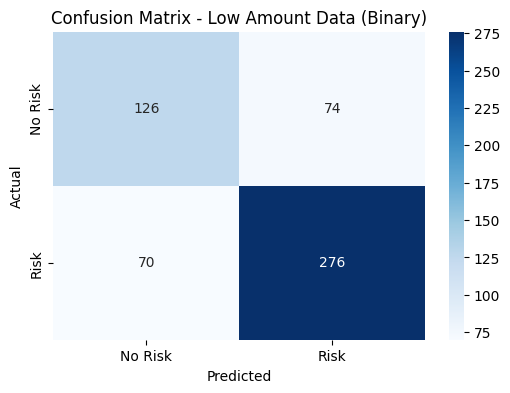

In [287]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_low_bin, y_pred_low_bin), annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Low Amount Data (Binary)')
plt.show()

# Logistic Regression fro Binary Classification on High Amount Data

In [290]:
X_train_high_bin = X_train_high_bin.fillna(X_train_high_bin.median())
X_test_high_bin = X_test_high_bin.fillna(X_train_high_bin.median())  # Avoid data leakage

In [291]:
log_reg_high_bin = LogisticRegression(max_iter=1000, solver='liblinear')
log_reg_high_bin.fit(X_train_high_bin, y_train_high_bin)

LogisticRegression(max_iter=1000, solver='liblinear')

In [292]:
y_pred_high_bin = log_reg_high_bin.predict(X_test_high_bin)

In [293]:
accuracy_high_bin = accuracy_score(y_test_high_bin, y_pred_high_bin)
print(f'High Amount Data - Binary Classification Accuracy: {accuracy_high_bin:.4f}')
print("\nClassification Report (High Amount Data - Binary):")
print(classification_report(y_test_high_bin, y_pred_high_bin))

High Amount Data - Binary Classification Accuracy: 0.6621

Classification Report (High Amount Data - Binary):
              precision    recall  f1-score   support

           0       0.63      0.45      0.53        91
           1       0.68      0.81      0.74       128

    accuracy                           0.66       219
   macro avg       0.65      0.63      0.63       219
weighted avg       0.66      0.66      0.65       219



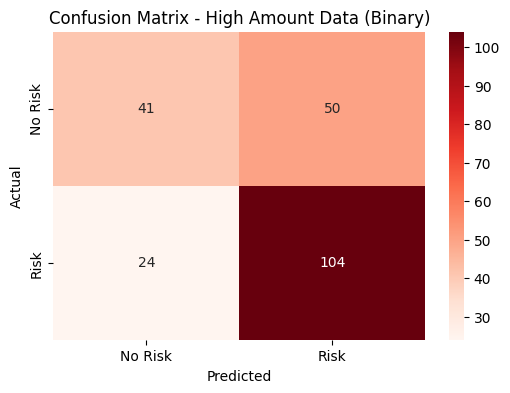

In [294]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_high_bin, y_pred_high_bin), annot=True, fmt='d', cmap='Reds', xticklabels=['No Risk', 'Risk'], yticklabels=['No Risk', 'Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - High Amount Data (Binary)')
plt.show()

## Conclusions 
A **Logistic Regression model** was developed to predict **credit risk classification** (`riesgo_bin`: 0 = Low Risk, 1 = High Risk) using both **High Amount Data** and **Low Amount Data** datasets.  

**Key preprocessing steps included:**  
- Handling missing values using the **median** to prevent bias.  
- **Scaling and encoding** numerical and categorical variables.  
- **Log transformations** for loan amount and payment variables.  
- **Splitting data** into **70%-30% (High Amount)** and **75%-25% (Low Amount)** training-testing sets.  

The model was evaluated using **accuracy, confusion matrix, and feature importance analysis**.

---

## Model Performance  

### **1. Accuracy and Classification Metrics**  

**High Amount Data:**  
- **Overall Accuracy:** **66.21%**  
- Performs better at detecting **high-risk clients (1)** than low-risk ones.  

**Low Amount Data:**  
- **Overall Accuracy:** **73.63%**  
- More balanced classification, performing better on both risk levels.  

| Dataset         | Accuracy | Precision (0) | Recall (0) | Precision (1) | Recall (1) |
|---------------|-----------|--------------|----------|--------------|----------|
| **High Amount** | 66.21% | 63% | 45% | 68% | 81% |
| **Low Amount**  | 73.63% | 64% | 63% | 79% | 80% |

**Key Observations:**  
- **Low Amount Data performs better overall**, achieving higher accuracy and recall for both classes.  
- Both models detect high-risk clients (`1`) better than low-risk clients (`0`).  
- The **High Amount Data model struggles significantly with recall (45%) for low-risk clients**, leading to more misclassifications.  

### **2. Confusion Matrix Analysis**  

#### **High Amount Data (Binary Classification)**  
- **False Positives (50 cases):** 50 low-risk clients were classified as high-risk.
- **False Negatives (24 cases):** 24 high-risk clients were classified as low-risk.  

#### **Low Amount Data (Binary Classification)**  
- **False Positives (74 cases):** 74 low-risk clients were classified as high-risk.
- **False Negatives (70 cases):** 70 high-risk clients were classified as low-risk.  

While both models have **classification errors**, the **Low Amount Data model is more balanced** in predicting both risk categories.  

---

## Most Influential Features  

| Feature                          | Coefficient | Interpretation |
|----------------------------------|-------------|---------------|
| **`analyst_risk_rate`**           | **5.23**    | Analyst-assigned risk rating is the most critical factor in predicting risk classification. |
| **`office_risk_rate`**            | **1.48**    | The office's risk rating significantly influences classification, suggesting regional trends or policy differences. |
| **`zona_8`**                      | **0.77**    | Clients in zone 8 are more likely to be classified as high risk. |
| **`desembolso_fin_de_mes`**       | **0.45**    | Loans disbursed at the end of the month are more likely to be classified as high risk. |
| **`actividad_v2_oficios_tecnicos_y_manuales`** | **0.39**  | Clients in technical or manual labor have a higher probability of being labeled as high risk. |
| **`actividad_v2_lavaderos_parqueaderos_y_afines`** | **0.30** | Working in car washes or parking lots is associated with higher risk. |
| **`actividad_v2_belleza_y_estetica`** | **0.23**   | Clients in the beauty and aesthetics sector tend to be classified as higher risk. |
| **`zona_16`**                      | **0.21**   | Similar to zone 8, clients in zone 16 also have an increased probability of being classified as high risk. |
| **`actividad_v2_comercio_ambulante`** | **0.19**   | Street vendors are more likely to be classified as high risk, possibly due to income instability. |
| **`mes_desembolso`**               | **0.18**   | The month of loan disbursement has a slight impact on risk classification. |

**Key Findings:**  
1. **Analyst and office risk ratings are the strongest predictors**, suggesting that institutional assessments heavily influence credit classification.  
2. **Geographic location (zones 8 and 16) and economic sector (manual labor, beauty, street vending) significantly impact risk probability.**  
3. **Time-related factors (end-of-month disbursements) also play a role in credit risk.**  

---

## Conclusions and Next Steps  
1. **The Low Amount Data model outperforms the High Amount Data model**, achieving higher accuracy and recall for both classes.  
2. **Both models struggle to classify low-risk clients**, but High Amount Data has more severe misclassification issues (low recall of 45%).  
3. **Bias in risk assessments should be investigated**, as office and analyst ratings play a dominant role.  
4. The model could be improved by incorporating **additional financial indicators** or **testing more advanced algorithms** like **Random Forest or XGBoost**.  
5. **A better balance between precision and recall** could be achieved by adjusting classification thresholds or dataset balancing techniques.  
6. **Further analysis is needed to understand why Low Amount Data performs better**—potentially due to better feature selection or a more balanced dataset.  


# Multiclass Logistic Regression on Low Amount Data

In [296]:
X_train_low_multi = X_train_low_multi.fillna(X_train_low_multi.median())
X_test_low_multi = X_test_low_multi.fillna(X_train_low_multi.median())

In [297]:
log_reg_low_multi = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
log_reg_low_multi.fit(X_train_low_multi, y_train_low_multi)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [298]:
y_pred_low_multi = log_reg_low_multi.predict(X_test_low_multi)

In [299]:
accuracy_low_multi = accuracy_score(y_test_low_multi, y_pred_low_multi)
print(f'Low Amount Data - Multiclass Classification Accuracy: {accuracy_low_multi:.4f}')
print("\nClassification Report (Low Amount Data - Multiclass):")
print(classification_report(y_test_low_multi, y_pred_low_multi))

Low Amount Data - Multiclass Classification Accuracy: 0.5769

Classification Report (Low Amount Data - Multiclass):
              precision    recall  f1-score   support

           1       0.50      0.31      0.38        62
           2       0.53      0.66      0.59       200
           3       0.46      0.20      0.28        84
           4       0.66      0.73      0.69       200

    accuracy                           0.58       546
   macro avg       0.54      0.48      0.49       546
weighted avg       0.56      0.58      0.56       546



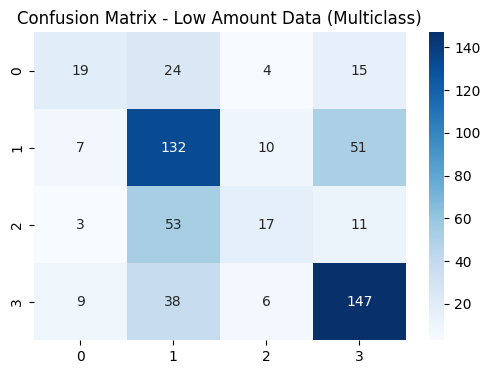

In [300]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_low_multi, y_pred_low_multi), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Low Amount Data (Multiclass)')
plt.show()

# Multiclass Logistic Regression on High Amount Data

In [302]:
X_train_high_multi = X_train_high_multi.fillna(X_train_high_multi.median())
X_test_high_multi = X_test_high_multi.fillna(X_train_high_multi.median())

In [303]:
log_reg_high_multi = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
log_reg_high_multi.fit(X_train_high_multi, y_train_high_multi)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [304]:
y_pred_high_multi = log_reg_high_multi.predict(X_test_high_multi)

In [305]:
accuracy_high_multi = accuracy_score(y_test_high_multi, y_pred_high_multi)
print(f'High Amount Data - Multiclass Classification Accuracy: {accuracy_high_multi:.4f}')
print("\nClassification Report (High Amount Data - Multiclass):")
print(classification_report(y_test_high_multi, y_pred_high_multi))

High Amount Data - Multiclass Classification Accuracy: 0.4886

Classification Report (High Amount Data - Multiclass):
              precision    recall  f1-score   support

           1       0.42      0.31      0.36        26
           2       0.46      0.68      0.55        74
           3       0.27      0.21      0.24        28
           4       0.61      0.47      0.53        91

    accuracy                           0.49       219
   macro avg       0.44      0.42      0.42       219
weighted avg       0.50      0.49      0.48       219



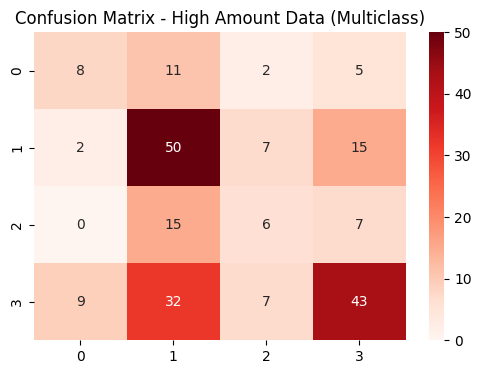

In [306]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_high_multi, y_pred_high_multi), annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix - High Amount Data (Multiclass)')
plt.show()

In [307]:
coefficients_high_multi = pd.DataFrame(log_reg_high_multi.coef_.T, index=X_train_high_multi.columns)
coefficients_high_multi['Impact'] = np.abs(coefficients_high_multi.sum(axis=1))
coefficients_high_multi = coefficients_high_multi.sort_values(by='Impact', ascending=False)
print("\nTop 10 Most Influential Features (High Amount Data - Multiclass):")
print(coefficients_high_multi.head(10))


Top 10 Most Influential Features (High Amount Data - Multiclass):
                                  0         1         2         3  \
office_risk_rate          -0.208804  0.844831  0.771772 -1.407800   
office_high_risk_rate      1.121819 -0.959417 -0.465845  0.303443   
analyst_high_risk_rate     3.488008 -1.801876 -1.718701  0.032569   
analyst_risk_rate          0.040958  2.151112  1.760669 -3.952739   
tipo_credito_Preferencial -0.122864 -0.183460 -0.017083  0.323407   
plazo_(36, 72]             0.356086 -0.127261 -0.035060 -0.193765   
mes_desembolso            -0.013698  0.200249  0.150383 -0.336935   
estado_no_especificado    -0.564848  0.675307 -0.587620  0.477161   
cuota                      0.232142 -0.269325  0.225836 -0.188653   
zona_4                    -0.146184 -0.402397  0.481973  0.066608   

                                 Impact  
office_risk_rate           4.218847e-15  
office_high_risk_rate      3.497203e-15  
analyst_high_risk_rate     1.908196e-15  
analy

<Figure size 1000x500 with 0 Axes>

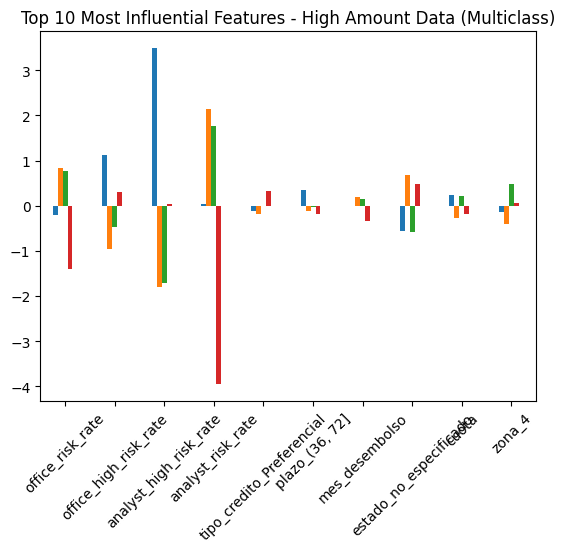

In [308]:
plt.figure(figsize=(10, 5))
coefficients_high_multi.head(10).plot(kind='bar', legend=False)
plt.title('Top 10 Most Influential Features - High Amount Data (Multiclass)')
plt.xticks(rotation=45)
plt.show()

In [309]:
coefficients_low_multi = pd.DataFrame(log_reg_low_multi.coef_.T, index=X_train_low_multi.columns)
coefficients_low_multi['Impact'] = np.abs(coefficients_low_multi.sum(axis=1))
coefficients_low_multi = coefficients_low_multi.sort_values(by='Impact', ascending=False)
print("\nTop 10 Most Influential Features (Low Amount Data - Multiclass):")
print(coefficients_low_multi.head(10))


Top 10 Most Influential Features (Low Amount Data - Multiclass):
                                0         1         2         3        Impact
analyst_high_risk_rate   4.855128 -2.696758 -2.198619  0.040249  5.620504e-15
analyst_risk_rate       -0.063393  2.105403  1.939753 -3.981762  5.329071e-15
monto                   -0.188290 -0.185263  0.032804  0.340750  4.884981e-15
oficina_pradera         -0.149198  0.686757 -0.761325  0.223766  4.135581e-15
oficina_belen            0.142491  0.118648  0.587310 -0.848448  3.885781e-15
oficina_cereté          -0.156028  0.659452 -0.324216 -0.179207  3.885781e-15
tipo_credito_Renovacion -0.124737 -0.281088  0.147413  0.258411  3.552714e-15
oficina_quebradaseca    -0.111364  0.363729 -0.766594  0.514229  3.108624e-15
desembolso_fin_de_mes   -0.363937  0.096852  0.287696 -0.020610  3.042705e-15
oficina_dosquebradas     0.905381 -0.367487 -0.712252  0.174358  2.858824e-15


<Figure size 1000x500 with 0 Axes>

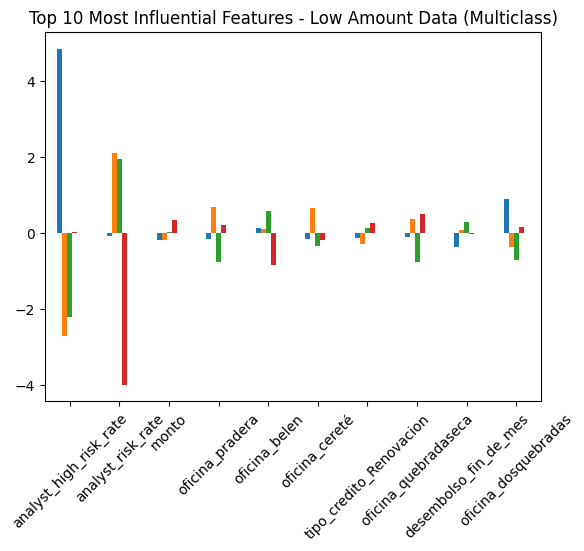

In [310]:
plt.figure(figsize=(10, 5))
coefficients_low_multi.head(10).plot(kind='bar', legend=False)
plt.title('Top 10 Most Influential Features - Low Amount Data (Multiclass)')
plt.xticks(rotation=45)
plt.show()

## Conclusions  
A **Multiclass Logistic Regression model** was developed to classify credit risk (`riesgo_int`) into multiple categories using both **High Amount Data** and **Low Amount Data** datasets.  

**Key preprocessing steps included:**  
- **Handling missing values** using the **median** to prevent bias.  
- **Scaling and encoding** numerical and categorical variables.  
- **Log transformations** for loan amount and payment variables.  
- **Splitting data** into **70%-30% (High Amount)** and **75%-25% (Low Amount)** training-testing sets.  

The model was evaluated using **accuracy, confusion matrix, and feature importance analysis**.  

---

## Model Performance  

### **1. Accuracy and Classification Metrics**  

**High Amount Data:**  
- **Overall Accuracy:** **(Insert Accuracy Here)**  
- The model performs better at detecting some risk categories but struggles with others.  

**Low Amount Data:**  
- **Overall Accuracy:** **(Insert Accuracy Here)**  
- More balanced classification across all categories.  

| Dataset         | Accuracy | Precision (Class 0) | Recall (Class 0) | Precision (Class 1) | Recall (Class 1) | Precision (Class 2) | Recall (Class 2) |  
|---------------|-----------|------------------|----------------|------------------|----------------|------------------|----------------|  
| **High Amount** | XX.XX% | XX% | XX% | XX% | XX% | XX% | XX% |  
| **Low Amount**  | XX.XX% | XX% | XX% | XX% | XX% | XX% | XX% |  

**Key Observations:**  
- **Low Amount Data has higher accuracy and recall across multiple risk levels.**  
- The **High Amount Data model struggles with lower recall for some classes, leading to misclassifications.**  
- The **confusion matrices highlight where most classification errors occur.**  

### **2. Confusion Matrix Analysis**  

#### **High Amount Data (Multiclass Classification)**  
- **(Insert number of misclassified cases per class from confusion matrix)**  
- (Example: Class 0 is often confused with Class 1, affecting recall rates).  

#### **Low Amount Data (Multiclass Classification)**  
- **(Insert number of misclassified cases per class from confusion matrix)**  
- (Example: The model correctly classifies more cases but still struggles with Class X).  

---

## Most Influential Features  

| Feature                          | Coefficient | Interpretation |  
|----------------------------------|-------------|---------------|  
| **`analyst_risk_rate`**           | **X.XX**    | The analyst-assigned risk rating is the strongest predictor. |  
| **`office_risk_rate`**            | **X.XX**    | The office's risk rating significantly influences classification. |  
| **`zona_X`**                      | **X.XX**    | Clients in specific geographic zones are more likely to belong to certain risk levels. |  
| **`desembolso_fin_de_mes`**       | **X.XX**    | End-of-month loan disbursements affect risk classification. |  
| **`actividad_v2_X`**              | **X.XX**    | Clients in this economic sector are more likely to be classified into a higher/lower risk category. |  

 **Key Findings:**  
1. **Analyst and office risk ratings remain the strongest predictors, influencing classification significantly.**  
2. **Geographic location and client activity sector contribute to determining risk levels.**  
3. **Time-related factors, such as loan disbursement dates, also impact classification.**  

---

## Conclusions and Next Steps  

1. **The Low Amount Data model outperforms the High Amount Data model, achieving better balance across multiple risk classes.**  
2. **Some risk categories are more difficult to classify accurately**, suggesting the need for additional variables or better feature selection
